# Data quality assessment for the Ocean Observatories Initiative (OOI) Global Station Papa Apex Profiler Mooring (GP02HYPM)

**Evaluation Date**: 7/20/2018

**Evaluator**: L.N. Ferris (lnferris@alum.mit.edu)

## Summary
This report summarizes an initial data quality review of the Ocean Observatories Initiative (OOI) Global Station Papa Apex Profiler Mooring (GP02HYPM). We focus on recovered data from deployments during 2016, and compare data from the upper and lower wire-following profilers with satellite sea surface temperature (SST), Argo float profiles, and reference-quality hydrographic data from the most recent U.S. GO-SHIP occupation of P16N (2015). This report is not a comprehensive review of the instruments and quality of data available.

In this report, we address data availability, metadata, timeseries, and profiles. The report is divided into the following sections:

1. Instruments included in this report
2. Time periods included in this report
3. Related metadata
3a. Vocabulary metadata
3b. Deployment information
3c. Calibration information
3d. Annotations
4. Full dataset
5. Comparison with OOI cruise data (not possible)
6. Comparison with Argo data and U.S. GO-SHIP P16N data
6a. Above 2000 meters
6b. Below 2000 meters
7. Notable results and actions required

In [0]:
from IPython.display import Image
Image(filename='OOI-ALL-Arrays.jpg',width=400)

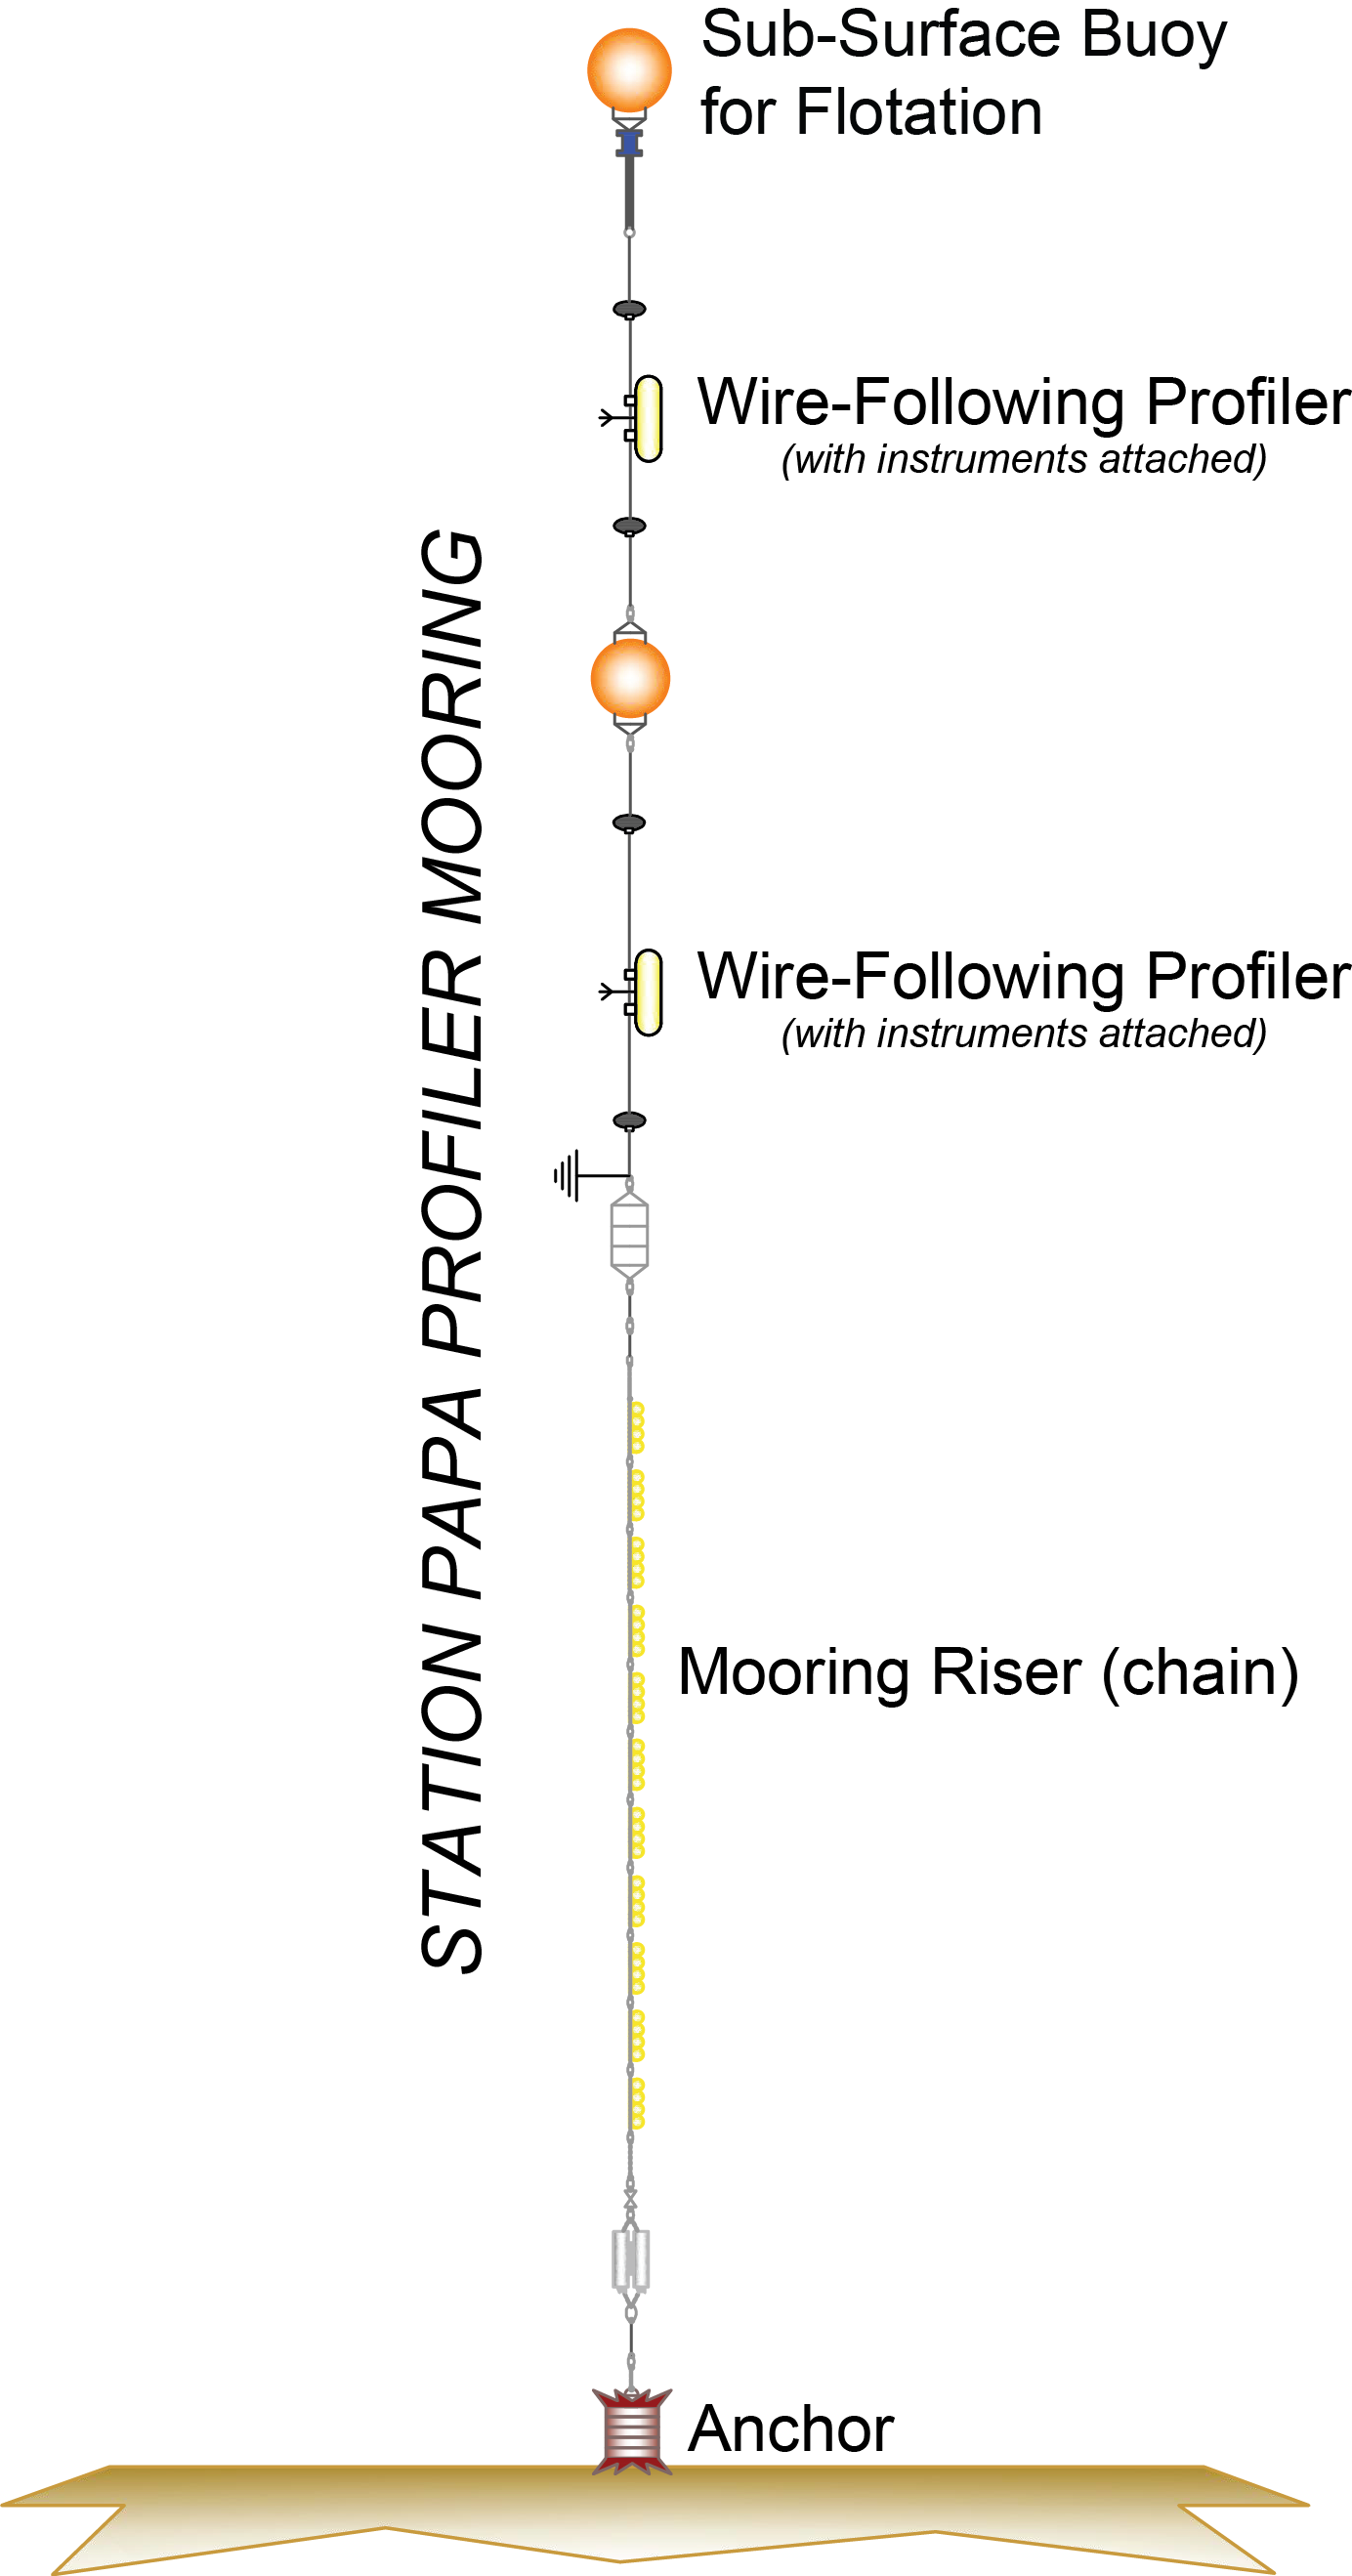

In [0]:
Image(filename='papa_profiler.png',width=300)

## 1. Instruments included in this report
In this report, we will evaluate the CTD and dissolved oxygen (DO) from the upper and lower wire-following profilers of the Global Station Papa Apex Profiler Mooring (GP02HYPM), focusing on data from deployments during 2016. (Deployments 3 and 4). 

Instrument | Reference Designator | Method | Stream
 -- | -- | -- | --
CTD Upper | [GP02HYPM-WFP02-04-CTDPFL000](http://ooi.visualocean.net/instruments/view/GP02HYPM-WFP02-04-CTDPFL000) | recovered-wfp | ctdpf_ckl_wfp_instrument_recovered
DO Upper | [GP02HYPM-WFP02-03-DOSTAL000](http://ooi.visualocean.net/instruments/view/GP02HYPM-WFP02-03-DOSTAL000) | recovered-wfp | dosta_ln_wfp_instrument_recovered
CTD Lower | [GP02HYPM-WFP03-04-CTDPFL000](http://ooi.visualocean.net/instruments/view/GP02HYPM-WFP03-04-CTDPFL000) | recovered-wfp | ctdpf_ckl_wfp_instrument_recovered
DO Lower | [GP02HYPM-WFP03-03-DOSTAL000](http://ooi.visualocean.net/instruments/view/GP02HYPM-WFP03-03-DOSTAL000) | recovered-wfp | dosta_ln_wfp_instrument_recovered

We focus on the recovered data stream in this review because it is available.

In [0]:
# Setup Instrument Variables
site = 'GP02HYPM'
nodes = ['WFP02', 'WFP03']
instruments = ['04-CTDPFL000','03-DOSTAL000']  
method = 'recovered_wfp'
streams = ['ctdpf_ckl_wfp_instrument_recovered','dosta_ln_wfp_instrument_recovered']

## 2. Time periods included in this report
We will focus on the following available deployment periods (see section 3b.) for evaluation:

Deployment | Start | Stop | Notes
 ----- | ----- | ----- | -----
 3 | 2016-01-01 00:00:00 | 2016-07-01 18:56:00 | (middle to end of Deployment 3)
 4 | 2016-07-03 02:05:00 | 2017-01-01 00:00:00 | (start to middle of Deployment 4)


## 3. Related metadata
The objective of this section is to review available metadata to verify that it exists and is correct.

In [0]:
# Setup the Python processing environment 
import requests
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as nc
import xarray as xr
import cmocean
import re
import os
import time

In [0]:
# API Information
USERNAME = '' # Your username
TOKEN =  '' # Your token

DATA_API = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
VOCAB_API = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
ASSET_API = 'https://ooinet.oceanobservatories.org/api/m2m/12587'

# Specify some functions to convert timestamps
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)
  
def convert_time(ms):
  if ms != None:
    return datetime.datetime.utcfromtimestamp(ms/1000)
  else:
    return None

### 3a. Vocabulary metadata
Obtain the basic vocabulary metadata to verify that these are the correct instruments.

In [0]:
# Make requests for each instrument in each node.
for node in nodes:
    for instrument in instruments:
        # Setup the API request url
        data_request_url ='/'.join((VOCAB_API,site,node,instrument))
        print(data_request_url)
        # Grab the information from the server
        r = requests.get(data_request_url, auth=(USERNAME, TOKEN))
        data = r.json()
        print(data,'\n')

https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv/GP02HYPM/WFP02/04-CTDPFL000
[{'@class': '.VocabRecord', 'model': 'SBE 52MP', 'manufacturer': 'Sea-Bird', 'vocabId': 1065, 'refdes': 'GP02HYPM-WFP02-04-CTDPFL000', 'instrument': 'CTD', 'tocL1': 'Global Station Papa', 'tocL2': 'Apex Profiler Mooring', 'tocL3': 'Wire-Following Profiler Upper', 'mindepth': 310.0, 'maxdepth': 2093.0}] 

https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv/GP02HYPM/WFP02/03-DOSTAL000
[{'@class': '.VocabRecord', 'model': 'Optode 4330', 'manufacturer': 'Aanderaa', 'vocabId': 1064, 'refdes': 'GP02HYPM-WFP02-03-DOSTAL000', 'instrument': 'Dissolved Oxygen', 'tocL1': 'Global Station Papa', 'tocL2': 'Apex Profiler Mooring', 'tocL3': 'Wire-Following Profiler Upper', 'mindepth': 310.0, 'maxdepth': 2093.0}] 

https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv/GP02HYPM/WFP03/04-CTDPFL000
[{'@class': '.VocabRecord', 'model': 'SBE 52MP', 'manufacturer': 'Sea-Bird', 'vocabId': 1071, 'refdes'

The basic vocabulary metadata seems adequate.

### 3b. Deployment information
Next, obtain deployment information for the instruments.  We will obtain all deployments available for 2016 and output  date ranges, latitude/longitude, asset ID, and sensor ID for each deployment.  Note that the **reference designator** specified above represents the geographical location of an instrument across all deployments (e.g. the CTD on the upper wire-following profiler at the Apex Profiler Mooring at Global Station Papa), the **Sensor ID** (and its Asset ID equivalent) represent the specific instrument hardware used for a given deployment.

In [0]:
df_all = pd.DataFrame() # Setup empty array to hold deployment information for all instruments
# Make requests for each instrument in each node.
for node in nodes:
    for instrument in instruments:
        # Setup the API request url
        data_request_url = ASSET_API + '/events/deployment/query'
        params = {
          'beginDT':'2016-01-01T00:00:00.000Z',
          'endDT':'2017-01-01T00:00:00.000Z',
          'refdes':site+'-'+node+'-'+instrument,   
        }
        # Grab the information from the server
        r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
        data = r.json()

        df = pd.DataFrame() # Setup empty array
        for d in data:
          df = df.append({
              'deployment': d['deploymentNumber'],
              'start': convert_time(d['eventStartTime']),
              'stop': convert_time(d['eventStopTime']),
              'latitude': d['location']['latitude'],
              'longitude': d['location']['longitude'],
              'sensor': d['sensor']['uid'],
              'asset_id': d['sensor']['assetId'],
            }, ignore_index=True)
        df_all = pd.concat([df_all, df],axis=0,sort=False)
df_all 

,asset_id,deployment,latitude,longitude,sensor,start,stop
0,644.0,3.0,50.07983,-144.80300,CGINS-CTDPFL-00115,2015-06-04 23:38:00,2016-07-01 18:56:00
1,563.0,4.0,50.07960,-144.80572,CGINS-CTDPFL-00134,2016-07-03 02:05:00,2017-07-16 15:20:00
0,2235.0,3.0,50.07983,-144.80300,CGINS-DOSTAL-01105,2015-06-04 23:38:00,2016-07-01 18:56:00
1,2400.0,4.0,50.07960,-144.80572,CGINS-DOSTAL-01480,2016-07-03 02:05:00,2017-07-16 15:20:00
0,560.0,3.0,50.07983,-144.80300,CGINS-CTDPFL-00132,2015-06-04 23:38:00,2016-07-01 18:56:00
1,931.0,4.0,50.07960,-144.80572,CGINS-CTDPFL-00107,2016-07-03 02:05:00,2017-07-16 15:20:00
0,2381.0,3.0,50.07983,-144.80300,CGINS-DOSTAL-01478,2015-06-04 23:38:00,2016-07-01 18:56:00
1,2744.0,4.0,50.07960,-144.80572,CGINS-DOSTAL-01086,2016-07-03 02:05:00,2017-07-16 15:20:00


### 3c. Calibration information
Calibration coefficients are used to generate derived data products. Get the calibration information for all instruments during Deployment 3 and 4. To return clear results for the API, we will limit the search to just one day within the deployment time range.

In [0]:
df_all = pd.DataFrame() # Setup empty array to hold calibrations for all instruments
# Make requests for each instrument in each node.
for node in nodes:
    for instrument in instruments:
        # Setup the API request url
        data_request_url = ASSET_API + '/asset/cal'
        params = {
# Uncomment the next two lines for one day Deployment 3. 
        #'beginDT':'2016-01-15T00:00:00.000Z',   
        #'endDT':'2016-01-16T00:00:00.000Z',
# Uncomment the next two lines for one day Deployment 4. 
        'beginDT':'2016-07-15T00:00:00.000Z',
        'endDT':'2016-07-16T00:00:00.000Z',    
        'refdes':site+'-'+node+'-'+instrument,
        }

        # Grab the information from the server
        r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
        data = r.json()

        # Reformat the data into a table
        df = pd.DataFrame() # Setup empty array
        for d in data:
            for dd in d['sensor']['calibration']:
                for ddd in dd['calData']:
                  df = df.append({
                    'value': ddd['value'],
                    'start': convert_time(ddd['eventStartTime']),
                    'stop': convert_time(ddd['eventStopTime']),
                    'name': ddd['eventName'],
                    'assetUid': ddd['assetUid'],
                    }, ignore_index=True)
        df_all = pd.concat([df_all, df],axis=0,sort=False)
df_all 

""


No calibration informtation is available through the system, but this is not a data problem because calibration information not stored at the instrument level for the requested instruments.

Note: The system uses the calibration value that are most recent before the deployment start date. Calibrations do not have an end date.  It is assumed they are valid until the next calibration for the specific asset. 

### 3d. Annotations
Finally, pull relevant annotations for the instruments.

In [0]:
df_all = pd.DataFrame() # Setup empty array to hold annotations for all instruments
# Make requests for each instrument in each node.
for node in nodes:
    for instrument in instruments:
        ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
        params = {
          'beginDT':int(datetime.date(2016,1,1).strftime('%s'))*1000,
          'endDT':int(datetime.date(2017,1,1).strftime('%s'))*1000,
          'refdes':site+'-'+node+'-'+instrument,
        }

        r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
        data = r.json()

        df = pd.DataFrame() # Setup empty array
        for d in data:
          df = df.append({
            'annotation': d['annotation'],
            'start': convert_time(d['beginDT']),
            'stop': convert_time(d['endDT']),
            'site': d['subsite'],
            'node': d['node'],
            'sensor': d['sensor'],
            'id': d['id']
          }, ignore_index=True)
        pd.set_option('display.max_colwidth', -1) # Show the full annotation text
        df_all = pd.concat([df_all, df],axis=0,sort=False)
df_all

,annotation,id,node,sensor,site,start,stop
0,Deployment 4: Instrument failed.,627.0,WFP02,04-CTDPFL000,GP02HYPM,2016-07-03 02:05:00,2016-07-03 02:05:00


There is only one annotation recorded in the system. The annotation is for the CTD on the upper wire-following profile, which failed during Deployment 4. Inspect here: [GP02HYPM-WFP02-04-CTDPFL000](http://ooi.visualocean.net/instruments/view/GP02HYPM-WFP02-04-CTDPFL000#annotations). Given that there are no annotations for Deployment 3, further investigation is required.

## 4. Full dataset
Make a request to generate data files from the OOI Data Portal using the API.

In [0]:
# Switch parameters back to full 2016 year.
params = {
  'beginDT':'2016-01-01T00:00:00.000Z',
  'endDT':'2017-01-01T00:00:00.000Z',    
  'format':'application/netcdf',
  'include_provenance':'true',
  'include_annotations':'true'
}

instrument_urls = [] # Make list to hold data urls [CTD Upper, DO Upper, CTD Lower, DO Lower].

# Make requests for each instrument in each node.
for node in nodes:
    for instrument, stream in zip(instruments,streams):
        # Create the full request URL
        data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))
        r = requests.get(data_request_url,params=params, auth=(USERNAME, TOKEN))
        data = r.json()
        instrument_urls.append(data['allURLs'][0])

# Print the data urls [CTD Upper, DO Upper, CTD Lower, DO Lower].
print('\n\n'.join(instrument_urls))        

https://opendap.oceanobservatories.org/thredds/catalog/ooi/lnferris@alum.mit.edu/20180723T004922-GP02HYPM-WFP02-04-CTDPFL000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/catalog.html

https://opendap.oceanobservatories.org/thredds/catalog/ooi/lnferris@alum.mit.edu/20180723T004929-GP02HYPM-WFP02-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered/catalog.html

https://opendap.oceanobservatories.org/thredds/catalog/ooi/lnferris@alum.mit.edu/20180723T004936-GP02HYPM-WFP03-04-CTDPFL000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/catalog.html

https://opendap.oceanobservatories.org/thredds/catalog/ooi/lnferris@alum.mit.edu/20180723T004944-GP02HYPM-WFP03-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered/catalog.html


Check that the data files have been successfully generated. We cannot proceed with the notebook until generation is complete.

In [0]:
for url in instrument_urls:
    %time  #Remove this line for running script outside of pylab.
    check_complete = data['allURLs'][1] + '/status.txt'
    for i in range(1800):
        r = requests.get(check_complete)
        if r.status_code == requests.codes.ok:
            print('request completed')
            break
        else:
                time.sleep(1)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.6 µs
request completed
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.6 µs
request completed
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 21.7 µs
request completed
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11 µs
request completed


Parse the THREDDS server to get a list of all of the available NetCDF files. Each deployment is separated into a separate file. By finding all files available, we can concatenate them.

In [0]:
def getNetCDF (url):
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    datasets = requests.get(url).text
    urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
    x = re.findall(r'(ooi/.*?.nc)', datasets)
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    datasets = [os.path.join(tds_url, i) for i in x]
    return datasets

In [0]:
datasets_UppCTD = getNetCDF(instrument_urls[0])
datasets_UppDO = getNetCDF(instrument_urls[1])
datasets_LowCTD = getNetCDF(instrument_urls[2])
datasets_LowDO = getNetCDF(instrument_urls[3])
print(datasets_UppCTD)
print(datasets_UppDO)

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/lnferris@alum.mit.edu/20180723T004922-GP02HYPM-WFP02-04-CTDPFL000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0004_GP02HYPM-WFP02-04-CTDPFL000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20160704T000003-20161230T143703.999150.nc', 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/lnferris@alum.mit.edu/20180723T004922-GP02HYPM-WFP02-04-CTDPFL000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered/deployment0003_GP02HYPM-WFP02-04-CTDPFL000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20160101T090002-20160627T025918.999021.nc']
['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/lnferris@alum.mit.edu/20180723T004929-GP02HYPM-WFP02-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered/deployment0004_GP02HYPM-WFP02-04-CTDPFL000-recovered_wfp-ctdpf_ckl_wfp_instrument_recovered_20160704T000003-20161230T143703.999150.nc', 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/lnferris@alum.

When requesting the NetCDF file for a DO instrument, a NetCDF for the synoptic CTD data is included. Remove these duplicates of the CTD instrument data.

In [0]:
def onlyDO(datasets):
    datasets_sel = []
    for i in datasets:
        if 'CTDPFL000' in i:
            pass
        else:
            datasets_sel.append(i)
    return datasets_sel     

In [0]:
datasets_UppDO = onlyDO(datasets_UppDO)
datasets_LowDO = onlyDO(datasets_LowDO)
print(datasets_UppDO)

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/lnferris@alum.mit.edu/20180723T004929-GP02HYPM-WFP02-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered/deployment0004_GP02HYPM-WFP02-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered_20160704T000204-20161231T120223.nc', 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/lnferris@alum.mit.edu/20180723T004929-GP02HYPM-WFP02-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered/deployment0003_GP02HYPM-WFP02-03-DOSTAL000-recovered_wfp-dosta_ln_wfp_instrument_recovered_20160101T090201-20160627T025707.nc']


Duplicates of the CTD instrument data have been successfully removed from the DO instrument datasets. Load all files into a single dataset using xarray. 

In [0]:
def makeCombinedDataset(datasets):
    # Load the data files
    ds = xr.open_mfdataset(datasets)
    # By default, OOI datasets use the 'obs' variable as the index, but time is more convenient
    ds = ds.swap_dims({'obs': 'time'}) 
    # Sort the data
    ds = ds.sortby('time'); 
    # Optional, this is used to optimize data processing
    ds = ds.chunk({'time': 100}) 
    return ds

In [0]:
ds_UppCTD = makeCombinedDataset(datasets_UppCTD)
###ds_UppDO = makeCombinedDataset(datasets_UppDO)
ds_LowCTD = makeCombinedDataset(datasets_LowCTD)
ds_LowDO = makeCombinedDataset(datasets_LowDO)




**There is a problem with the Upper DO dataset ("MergeError: conflicting values for variable 'time' on objects to be combined"), which is why this as been commented out. The data team is looking into this issue.**




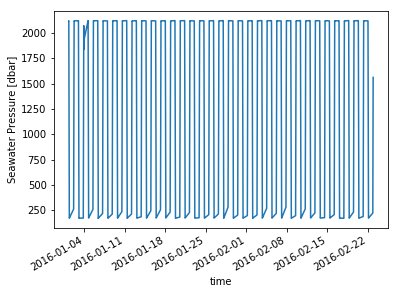

In [0]:
ds_UppCTD['ctdpf_ckl_seawater_pressure'][0:500000].plot(); # Pressure (dbar) from the upper profiler.

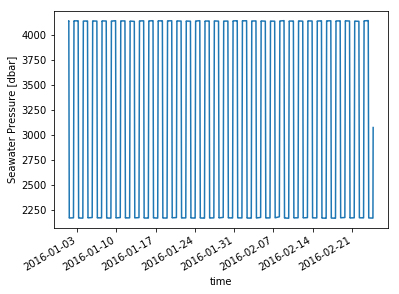

In [0]:
ds_LowCTD['ctdpf_ckl_seawater_pressure'][0:500000].plot(); # Pressure (dbar) from the lower profiler.

Both the upper and lower wire-following profilers appear to profile to consistent depths during this time period. The Apex Profiler Mooring is anchored at a nominal depth of 4219 meters.

Next, inspect the full timeseries of temperature.

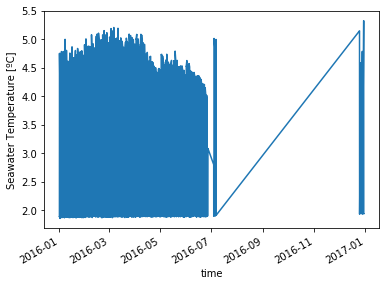

In [0]:
ds_UppCTD['ctdpf_ckl_seawater_temperature'].plot(); # Temperature (deg C) from upper profiler CTD.

For the upper profiler CTD, upper (assuming stratification) ocean temperature decreases from the beginning of March 2016 through the end of Deployment 3 in July, which requires further investigation since the sea surface might be expected to warm during this season. There is a persistent data outage following the instrument failure at the start of Deployment 4. This instrument does not recover. 

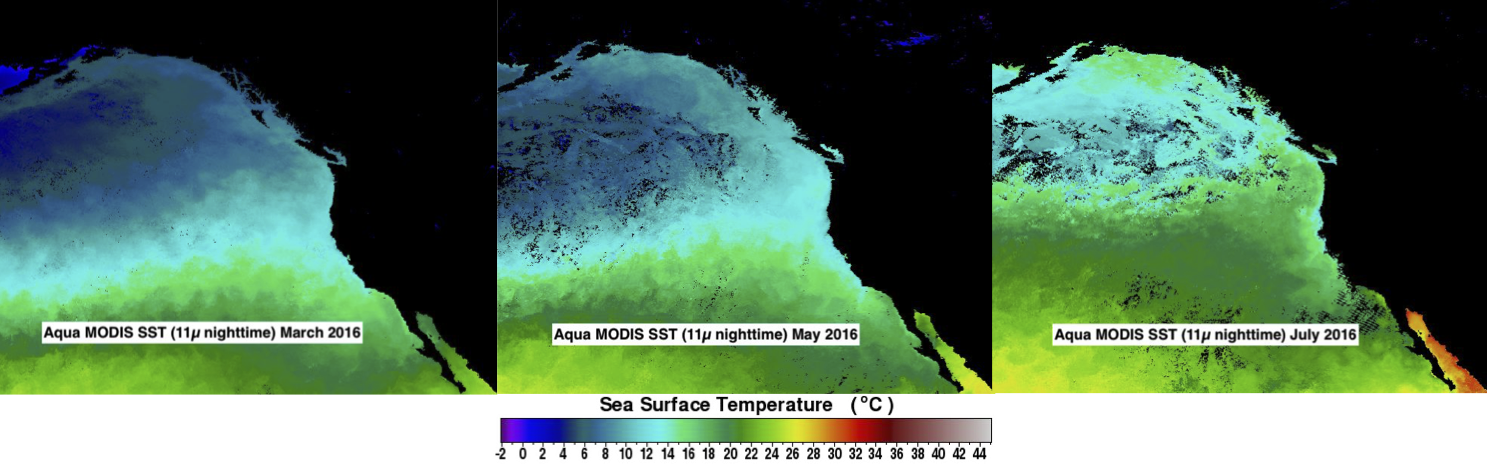

In [0]:
from IPython.display import Image
Image(filename='MODIS_AQSSTimage.png')

Monthy averaged sea surface temperature from  [MODIS Aqua](https://oceancolor.gsfc.nasa.gov/) shows that sea surface temperature over Global Station Papa actually increased from March 2016 through July 2016. However, sea surface temperature is not synonymous with the minimum depth of the CTD profile, which begins below 50 meters. The mismatch between trend in upper ocean temperature and sea surface temperature could be related to seasonal mixed layer evolution. Comparison with ship or float-based CTD is needed to validate this instrument.

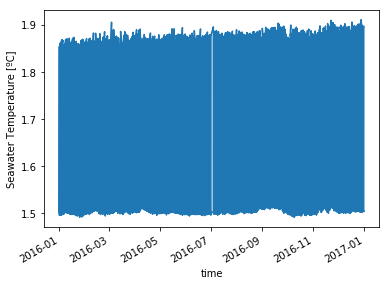

In [0]:
ds_LowCTD['ctdpf_ckl_seawater_temperature'].plot(); # Temperature (deg C) from lower profiler CTD.

For the lower profiler CTD, all data are present. There is a slight but steady increase in mid-depth temperature over the year 2016. It is unclear whether this is real or sensor drift. Further investigation is also required.

Create histograms to see the full range of temperature and salinity data.

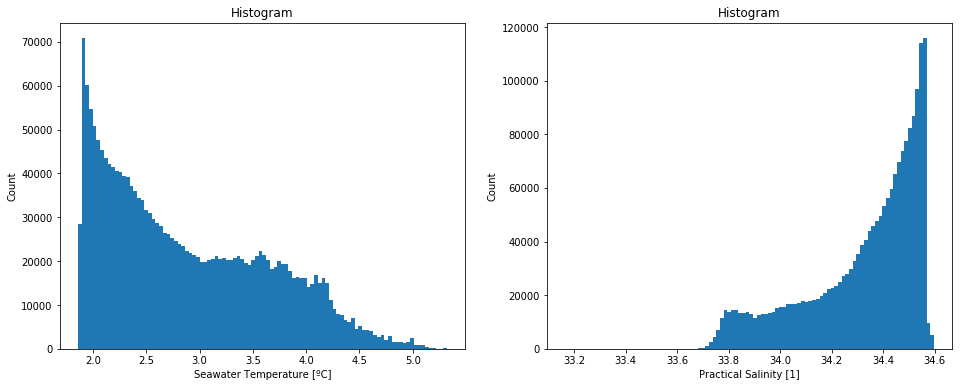

In [0]:
# Upper profiler CTD
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6)) 
ds_UppCTD['ctdpf_ckl_seawater_temperature'].plot.hist(bins=100, ax=ax1)
ds_UppCTD['practical_salinity'].plot.hist(bins=100, ax=ax2);

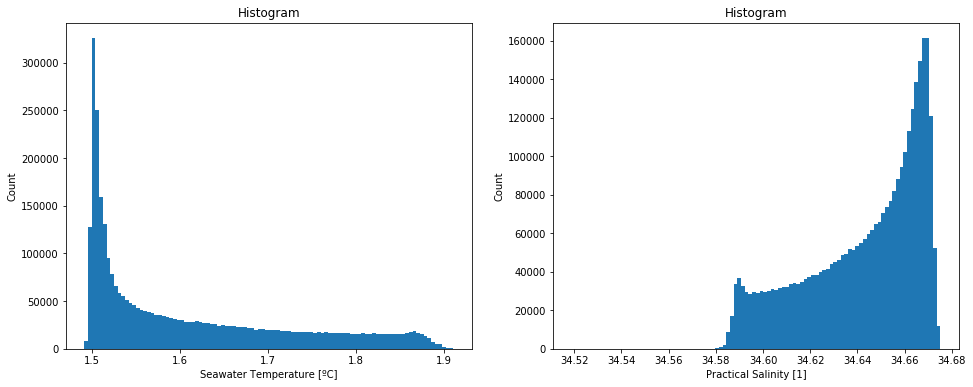

In [0]:
# Lower profiler CTD
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6)) 
ds_LowCTD['ctdpf_ckl_seawater_temperature'].plot.hist(bins=100, ax=ax1)
ds_LowCTD['practical_salinity'].plot.hist(bins=100, ax=ax2);

The data does not appear to contain notable outliers. 

Next, create a timeseries of profiles. **Note: it was found that this profiler mooring uses the variable name "dissolved_oxygen", which is inconsistent with the variable name "corrected_dissolved_oxygen" associated with other OOI DO instrumentation.**

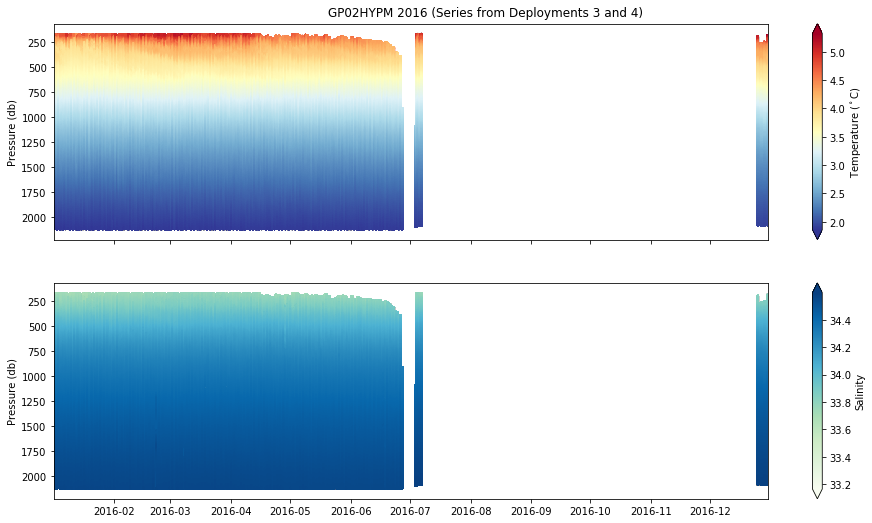

In [0]:
# Upper profiler CTD

dtime = ds_UppCTD['time'].values
pressure = ds_UppCTD['ctdpf_ckl_seawater_pressure'].values
temperature = ds_UppCTD['ctdpf_ckl_seawater_temperature'].values
salinity = ds_UppCTD['practical_salinity'].values

fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(16,8))
sc1 = ax1.scatter(dtime, pressure, c=temperature, cmap='RdYlBu_r', s=2)
sc2 = ax2.scatter(dtime, pressure, c=salinity, cmap='GnBu', s=2)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity')

ax1.set_ylabel('Pressure (db)')
ax2.set_ylabel('Pressure (db)')

fig.suptitle('GP02HYPM 2016 (Series from Deployments 3 and 4)')
fig.subplots_adjust(top=0.95);

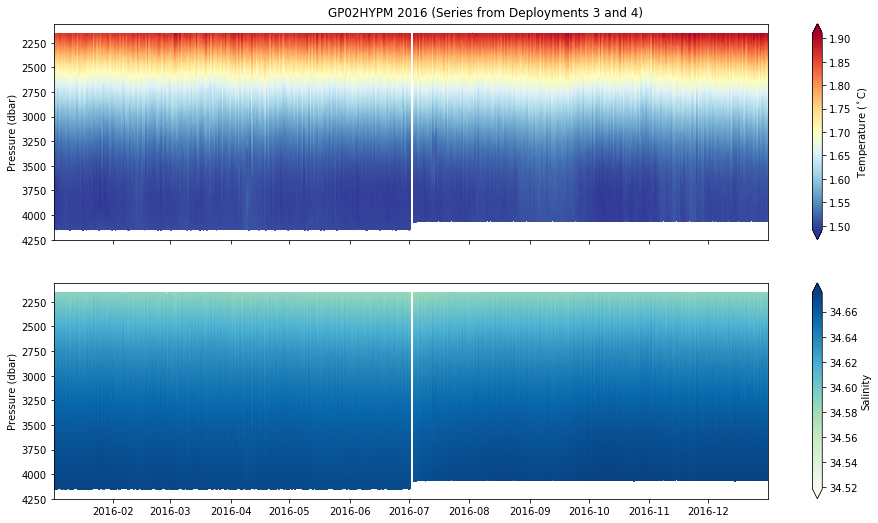

In [0]:
# Lower profiler CTD

dtime = ds_LowCTD['time'].values
pressure = ds_LowCTD['ctdpf_ckl_seawater_pressure'].values
temperature = ds_LowCTD['ctdpf_ckl_seawater_temperature'].values
salinity = ds_LowCTD['practical_salinity'].values

fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(16,8))
sc1 = ax1.scatter(dtime, pressure, c=temperature, cmap='RdYlBu_r', s=2)
sc2 = ax2.scatter(dtime, pressure, c=salinity, cmap='GnBu', s=2)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity')

ax1.set_ylabel('Pressure (dbar)')
ax2.set_ylabel('Pressure (dbar)')

fig.suptitle('GP02HYPM 2016 (Series from Deployments 3 and 4)')
fig.subplots_adjust(top=0.95);

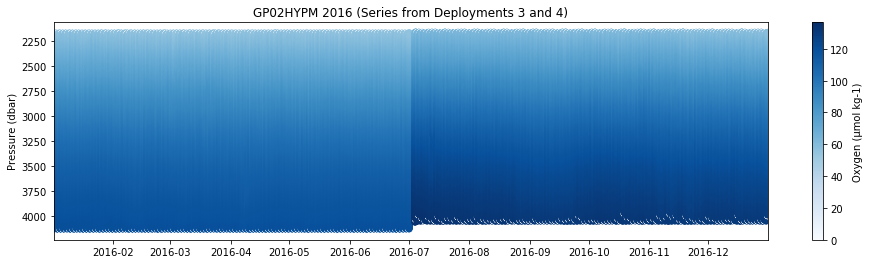

In [0]:
# Lower profiler DO

dtime = ds_LowDO['time'].values
pressure = ds_LowDO['int_ctd_pressure'].values # Interpolated pressure is a hidden variable for DO instrument.
oxygen = ds_LowDO['dissolved_oxygen'].values

fig,ax1 = plt.subplots(1,1,figsize=(16,4))
sc1 = ax1.scatter(dtime, pressure, c=oxygen, cmap='Blues')

ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Oxygen (%s)' % ds_LowDO['dissolved_oxygen'].units) # Get units attribute

ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('GP02HYPM 2016 (Series from Deployments 3 and 4)');

**There is a serious calibration error with the Lower profiler DO instrument used for Deployment 3, the DO instrument used for Deployment 4, or both instruments. This is demonstrated by the full-depth unreasonable shift in oxygen concentration between the deployments. Since we were unable to inspect DO data from the Upper profiler DO instrument, it is possible that the upper DO instrument also has a calibration error.**

## 5. Comparison with OOI cruise data (not possible)

**We attempted to get access the cruise data on [Alfresco Explorer](https://alfresco.oceanobservatories.org/alfresco/faces/jsp/browse/browse.jsp), but no cruise data is available for the following cruises:**

* Station_Papa-01_MV-130_2013-07-15
* Station_Papa-03_TN-323_2015-05-29 
* Station_Papa-04_RB-16-05_2016-06-22
* Station_Papa-05_SR-17-10_2017-07-07
* Station_Papa-06_SR1811_2018-07-17

**The only cruise data available is that for Station_Papa-02_MV-1404_2014-06-10. It is not possible to conduct validation using OOI cruise data.**


## 6. Comparison with Argo and U.S. GO-SHIP P16N data

Since OOI cruise data is not available for validation of individual profiles, we turn to data from the Argo float array and U.S. GO-SHIP to validate the general trend of CTD and DO profiles. Argo float data can be used for CTD in the upper 2000 meters. Data from U.S. GO-SHIP P16N, which was collected in May/June 2015 on the NOAAS Ronald H. Brown, can be used for both CTD and DO for the full depth of the water column. This data and associated cruise report is available at the [CCHDO website](https://cchdo.ucsd.edu/cruise/33RO20150525).

Download and plot Argo profiles from [USGODAE Argo GDAC Data Browser](http://www.usgodae.org/cgi-bin/argo_select.pl) near Global Station Papa (48-52°N,146-142°W) for January 1, 2016 through January 1, 2017. Download and plot GO-SHIP P16N stations (48-52°N,~152°W) near Global Station Papa. Note that the actual location of Global Station Papa Apex Profiler Mooring (GP02HYPM)
is 50.07°N, 144.80°W. All temperature units are in °C. All salinity units are in practical salinity units. All pressure units are in dbar.

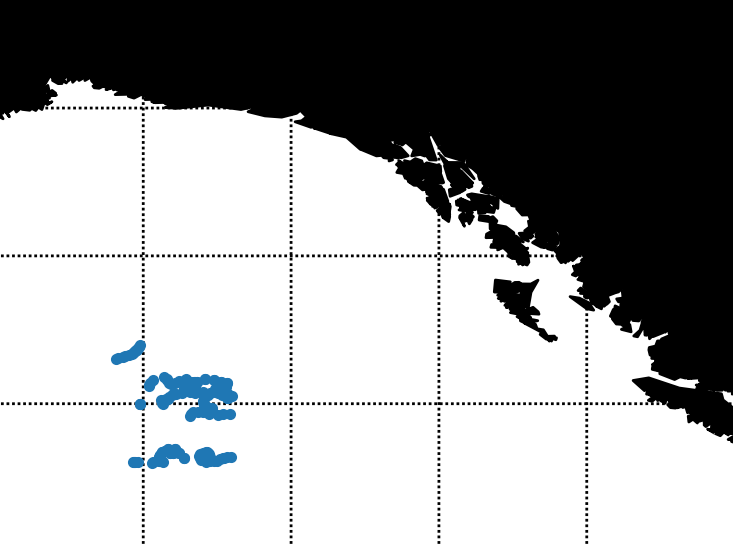

In [0]:
# Map of Argo profiles near Global Station Papa.
Image(filename='PapaArgoMap.png',width=425, height=425)

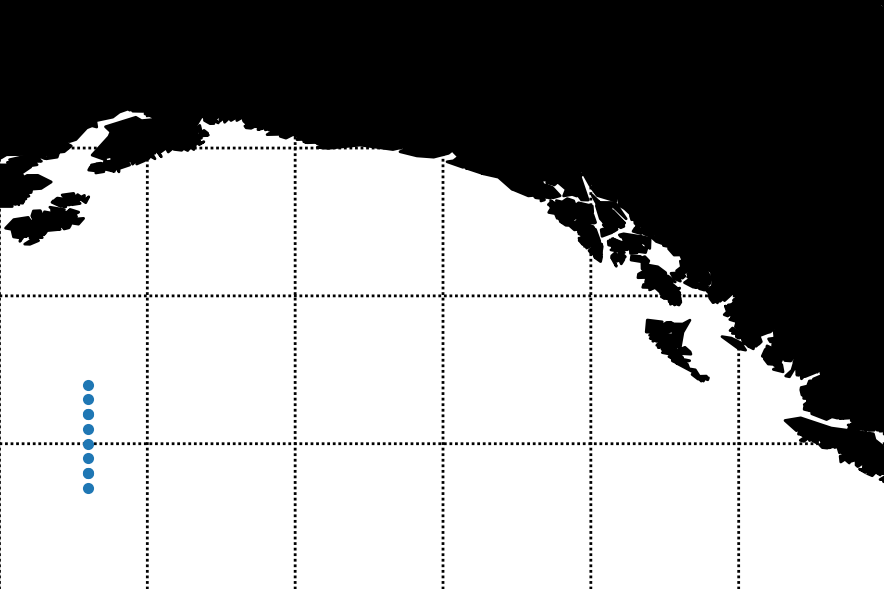

In [0]:
# Map of GO-SHIP P16N profiles near Global Station Papa.
Image(filename='P16NMap.png',width=425, height=425)

## 6a. Above 2000 meters

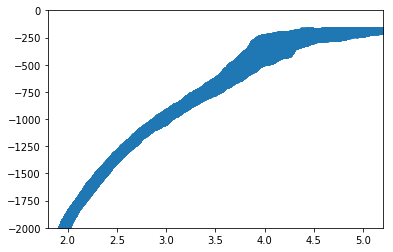

In [0]:
# Plot temperature vs. pressure vertical profiles from GP02HYPM upper profiler.
plt.plot(ds_UppCTD['ctdpf_ckl_seawater_temperature'],-1*ds_UppCTD['ctdpf_ckl_seawater_pressure'],marker='.',linestyle='None')
plt.axis([1.8, 5.2, -2000.0, 0.0 ]);

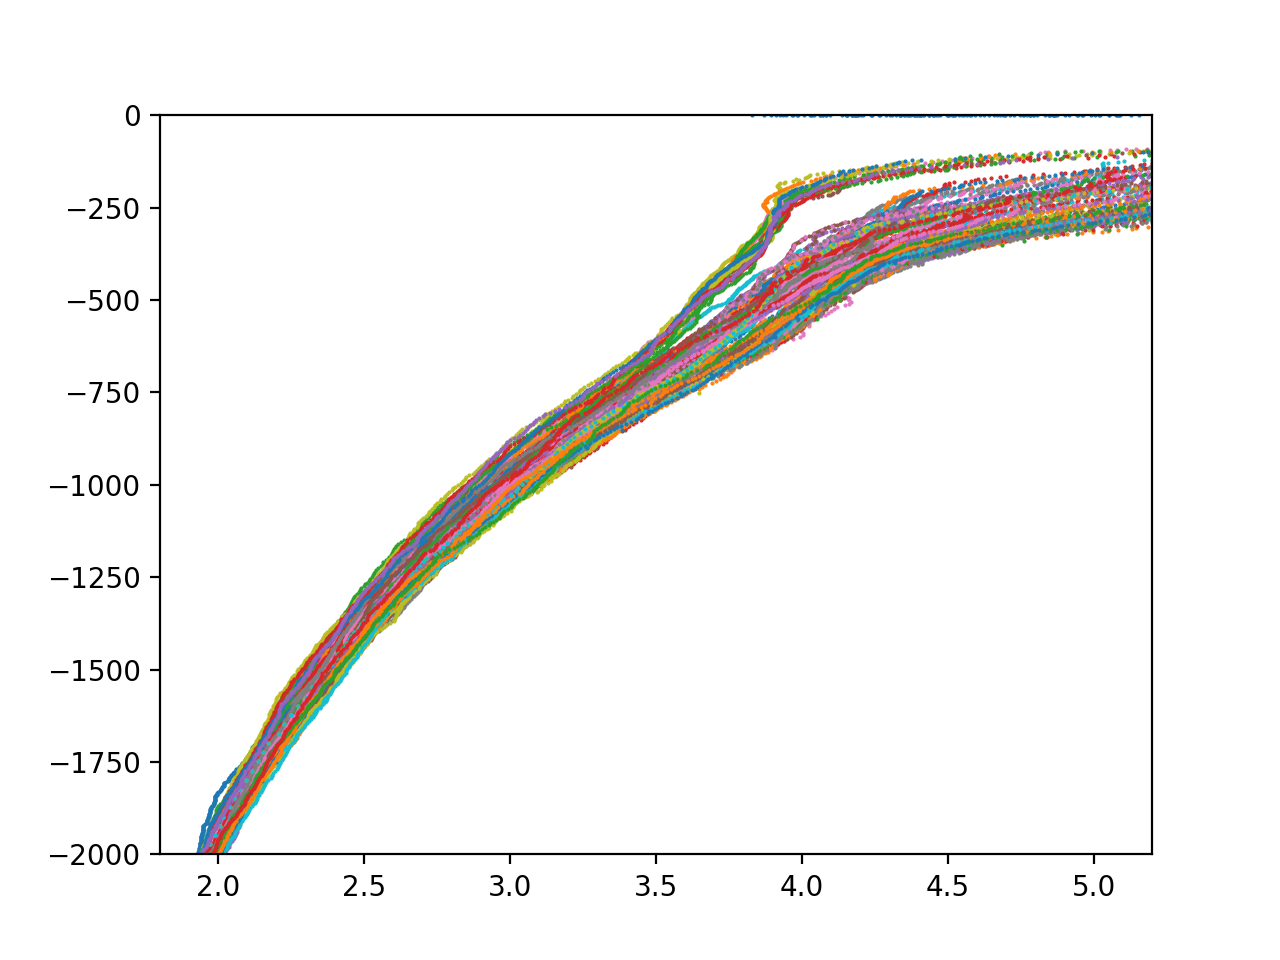

In [0]:
# Import temperature vs. pressure vertical profiles from Argo floats.
Image(filename='PapaArgoTemp.png',width=425, height=425)

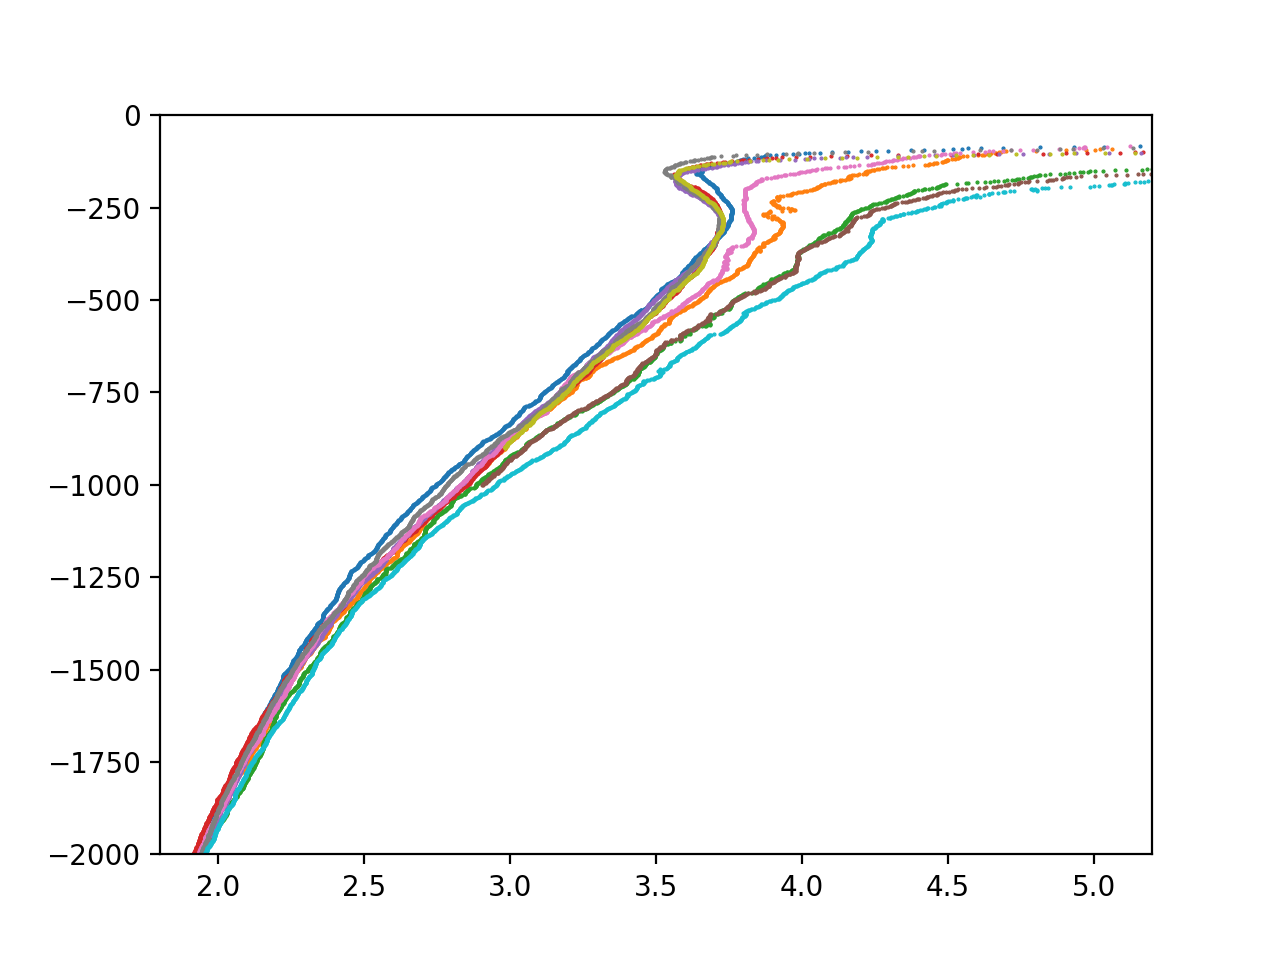

In [0]:
# Import temperature vs. pressure vertical profiles from GO-SHIP P16N.
Image(filename='P16N_UppTemp.png',width=425, height=425)

While individual profiles cannot be validated, temperature profiles are in reasonable agreement.

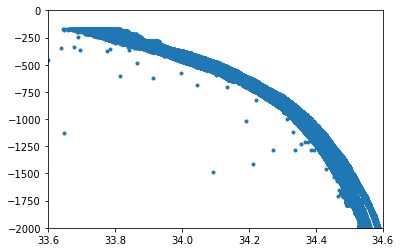

In [0]:
# Plot salinity vs. pressure vertical profiles from GP02HYPM upper profiler.
plt.plot(ds_UppCTD['practical_salinity'],-1*ds_UppCTD['ctdpf_ckl_seawater_pressure'],marker='.',linestyle='None')
plt.axis([33.6, 34.6, -2000.0, 0.0 ]);

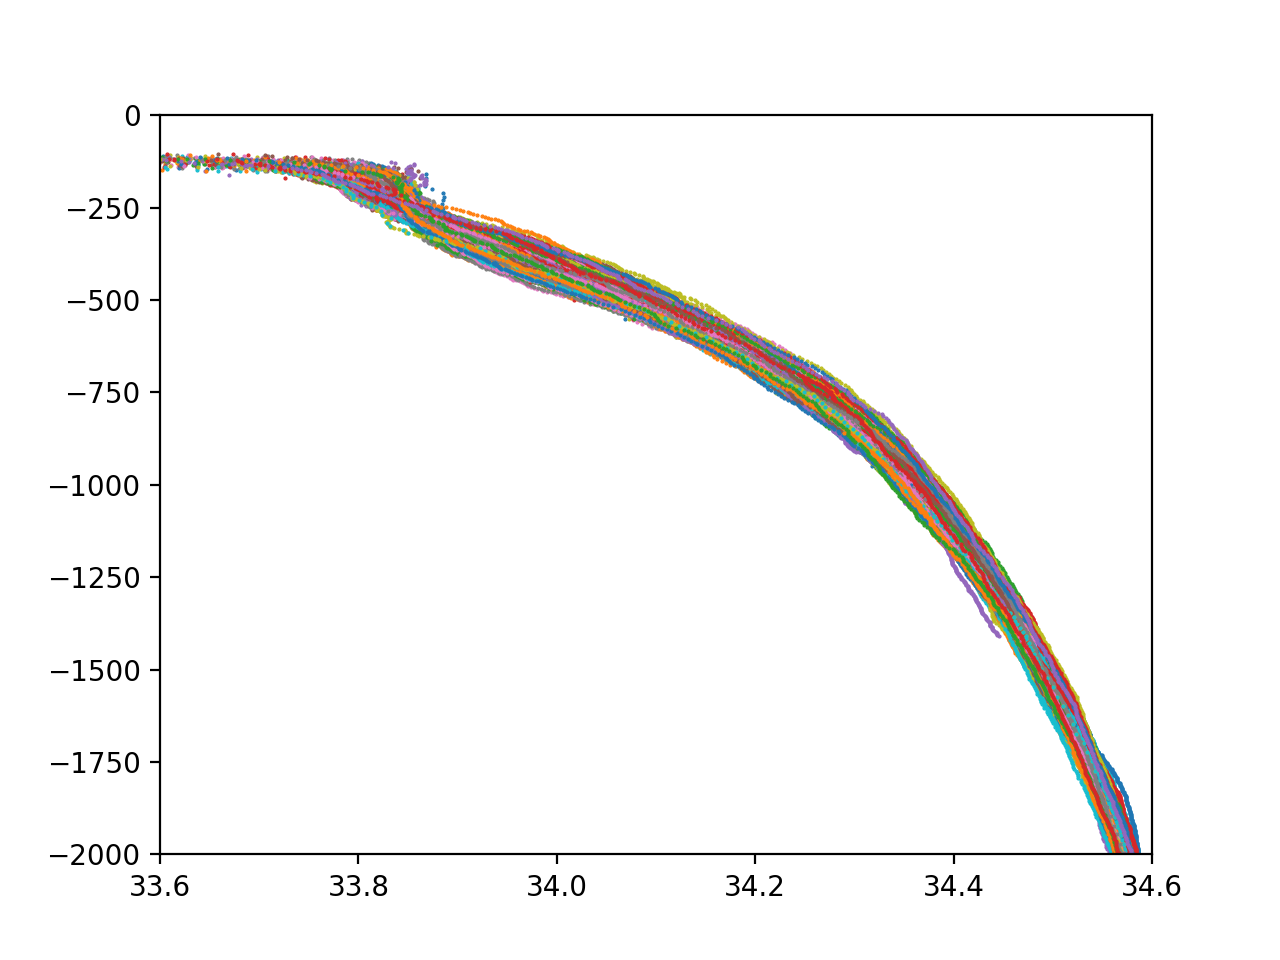

In [0]:
# Import salinity vs. pressure vertical profiles from Argo floats.
Image(filename='PapaArgoSal.png',width=425, height=425)

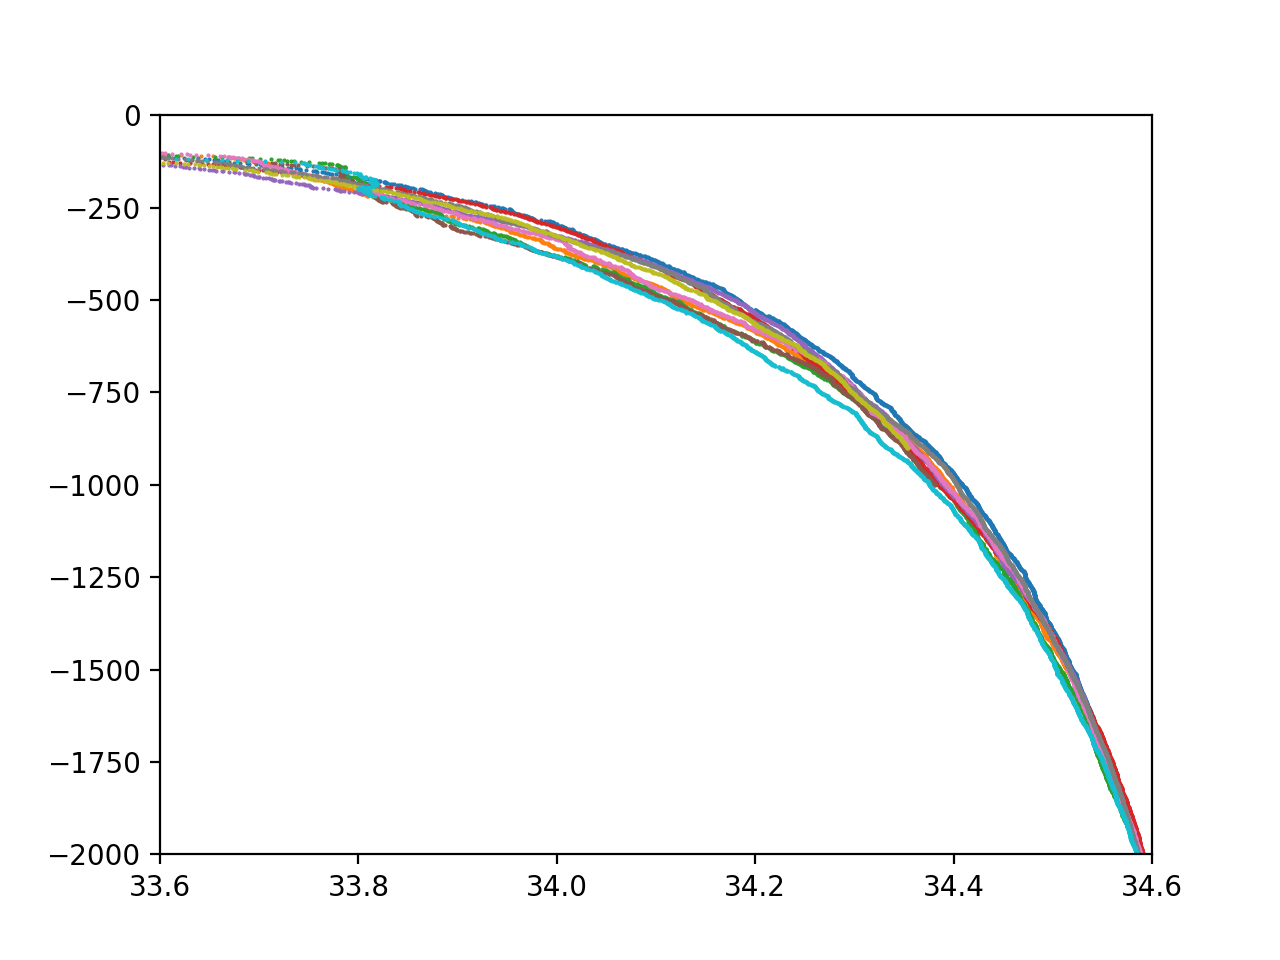

In [0]:
# Import salinity vs. pressure vertical profiles from GO-SHIP P16N.
Image(filename='P16N_UppSal.png',width=425, height=425)

While individual profiles cannot be validated, salinity profiles are in reasonable agreement. There are some data spikes in salinity data from the Global Station Papa Apex Profiler Mooring.

## 6b. Below 2000 meters

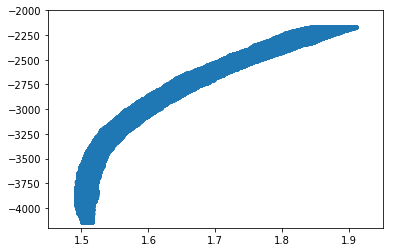

In [0]:
# Plot temperature vs. pressure vertical profiles from GP02HYPM lower profiler.
plt.plot(ds_LowCTD['ctdpf_ckl_seawater_temperature'],-1*ds_LowCTD['ctdpf_ckl_seawater_pressure'],marker='.',linestyle='None')
plt.axis([1.45, 1.95, -4200.0, -2000.00 ]);

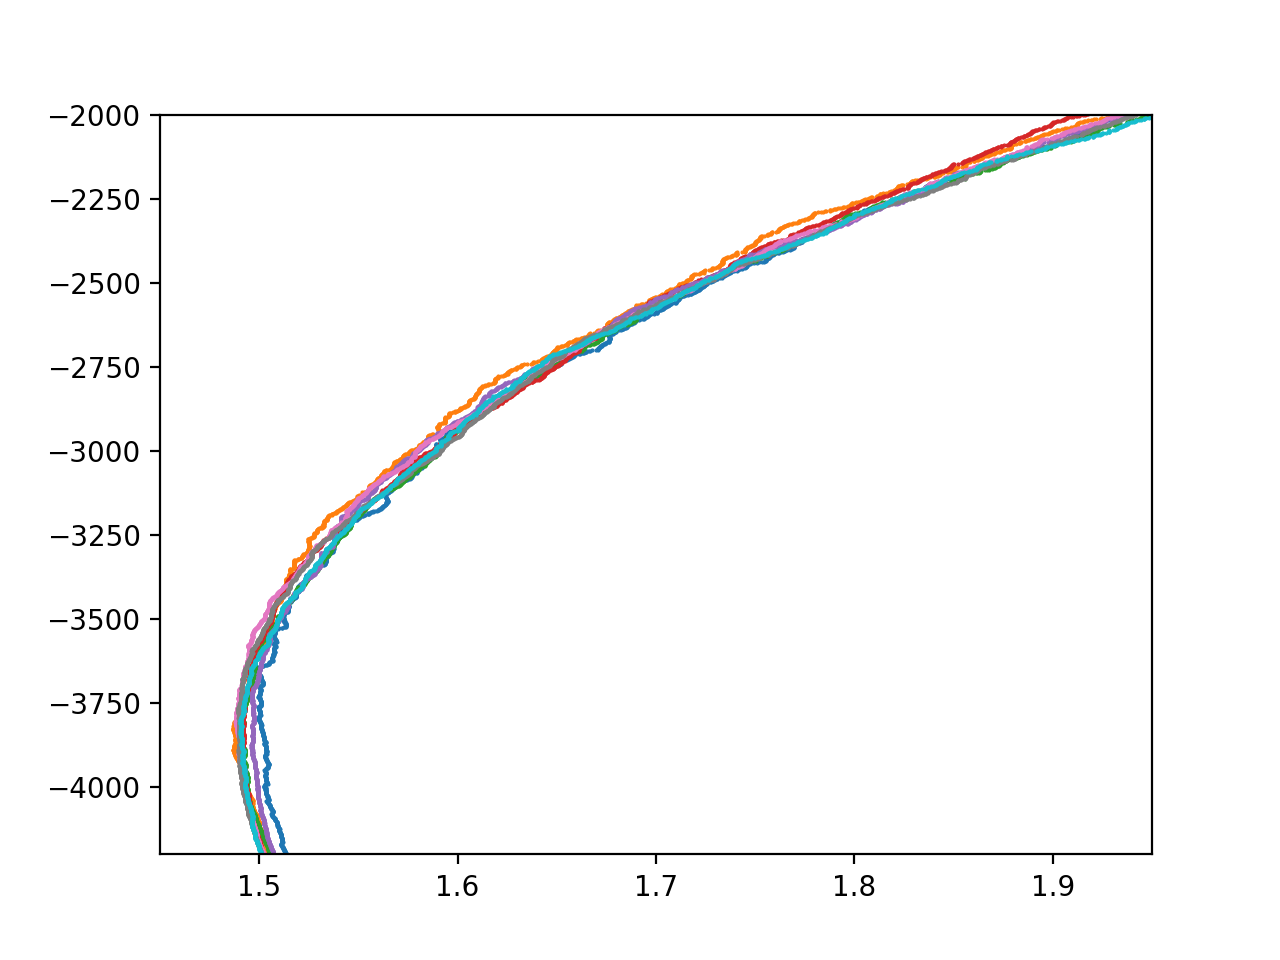

In [0]:
# Import temperature vs. pressure vertical profiles from GO-SHIP P16N.
Image(filename='P16N_LowTemp.png',width=425, height=425)

While individual profiles cannot be validated, temperature profiles are in reasonable agreement.

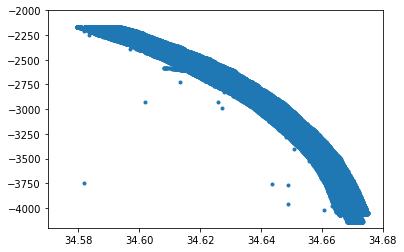

In [0]:
# Plot salinity vs. pressure vertical profiles from GP02HYPM lower profiler.
plt.plot(ds_LowCTD['practical_salinity'],-1*ds_LowCTD['ctdpf_ckl_seawater_pressure'],marker='.',linestyle='None')
plt.axis([34.57, 34.68, -4200.0, -2000.0 ]);

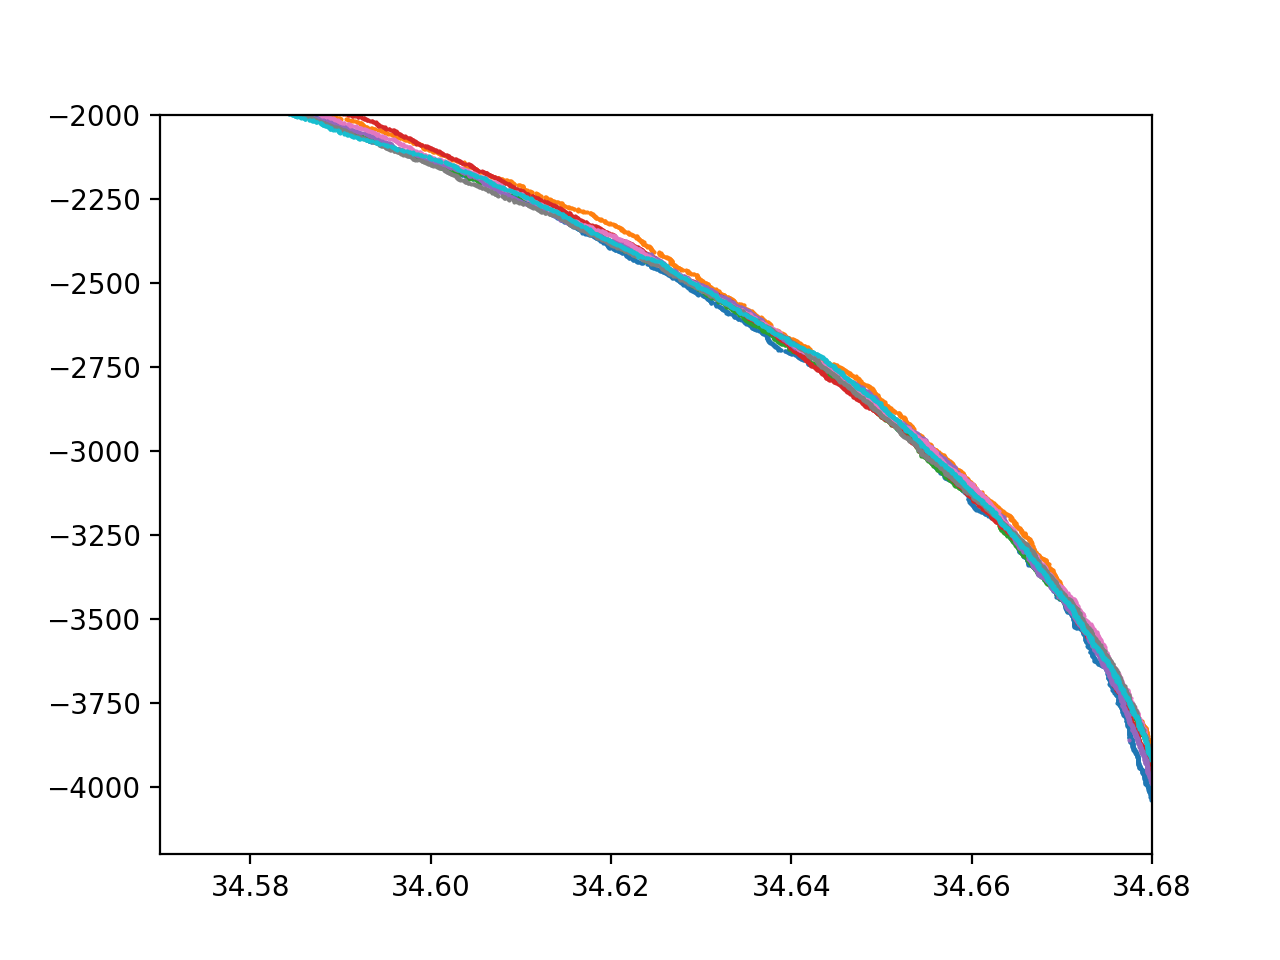

In [0]:
# Import salinity vs. pressure vertical profiles from GO-SHIP P16N.
Image(filename='P16N_LowSal.png',width=425, height=425)

**Salinity profiles of the abyssal waters differ by approximately 0.02 psu, but data from GP02HYPM and P16N are not synoptic so it is unclear what component of this is error. There are also data spikes in salinity data from the Global Station Papa Apex Profiler Mooring.**

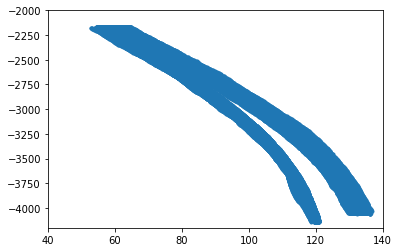

In [0]:
# Plot dissolved oxygen vs. pressure vertical profiles from GP02HYPM lower profiler.
pressure = ds_LowDO['int_ctd_pressure'].values
oxygen = ds_LowDO['dissolved_oxygen'].values
plt.plot(oxygen,-1*pressure,marker='.',linestyle='None')
plt.axis([40.0, 140.0, -4200.0, -2000.0 ]);

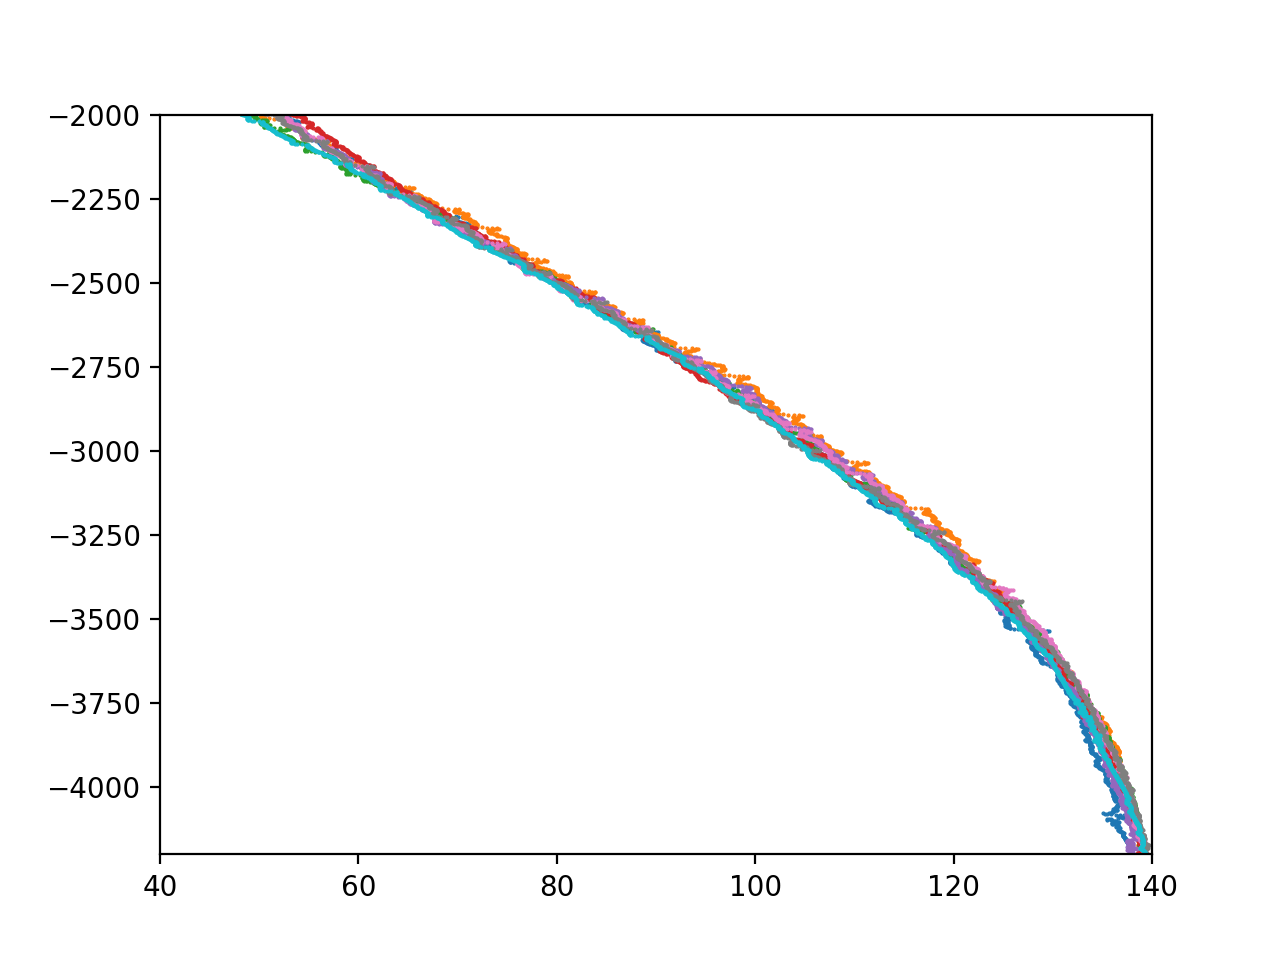

In [0]:
# Import dissolved oxygen vs. pressure vertical profiles from GO-SHIP P16N.
Image(filename='P16N_LowDO.png',width=425, height=425)

The vertical profiles of dissolved oxygen (umol kg-1) highlight the calibration error between Deployment 3 and Deployment 4. Dissolved oxygen data from GO-SHIP P16N suggests that Deployment 3 is the more incorrect timeseries of dissolved oxygen, since data from Deployment 4 is in better agreement with GO-SHIP P16N.

## 7. Notable results and actions required


Based on this initial analysis of the Global Station Papa Apex Profiler Mooring (GP02HYPM) during Deployment 3 and Deployment 4 in 2016, we find several substantial problems that require action.

Data Availability:
  
  **i) Data for the dissolved oxygen (DO) instrument on the upper wire-following profiler is possibly available but in a format that cannot be opened without throwing an unresolved error. See section 4, function xarray.open_mfdataset(datasets).**
 
 **ii) CTD data for the upper wire-following profiler is unavailable for most of Deployment 4 due to instrument failure. See section 4.**
 
 **iii) Associated cruise/shipboard data for 5 out of the 6 cruises to Global Station Papa are missing from the system. See section 5.**
  
Metadata:
  
  **i) The existing annotation about the upper CTD instrument failure during Deployment 4 should be edited to reinforce that this was a persistent instrument failure instead of a brief instrument outage. See section 3d.**
 
 **ii) The lower DO instrument (and possibly the upper DO instrument) requires prompt annotation to notify users of a serious calibration error.**
 
Timeseries and Profiles:
  
 **i) Individual CTD profiles are mostly in reasonable agreement with nearby Argo float profiles and GO-SHIP P16N data from 2015. Salinity profiles of the abyssal waters differ by approximately 0.02 psu, but data from GP02HYPM and P16N are not synoptic so it is unclear if this is error.**
 
 **ii) DO vertical profiles support that there is a serious calibration error in the lower DO instrument.**